In [ ]:
'''
Systematic analysis of Degenhart stabilizer performance.
'''

In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct, daysBetween
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from stabilizer_utils import *


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files = glob.glob('D:/T5_ClosedLoop/*')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:
from copy import deepcopy
from stabilizer import Stabilizer
from scipy.linalg import orthogonal_procrustes

diffs           = list()
model_type      = 'FactorAnalysis'
component_sweep = [10, 12, 14, 16, 18]
B_sweep         = [20, 40, 60, 80, 100, 120, 140, 160]
thresh          = 0.1

dayA_latentscores = np.zeros((len(component_sweep), len(files) - 1)) 
dayA_fullscores   = np.zeros((2, len(files) - 1)) # row 0: full decoder (train), row 1: full decoder (test)

dayB_latentscores = np.zeros((len(component_sweep), len(B_sweep), len(files) - 1)) 
dayB_fullscores   = np.zeros((3, len(files) - 1)) # 0: no recalibration, 1: mean recalibration, 2: full recalibration

for i in range(len(files) - 1):
    dayA = DataStruct(files[i])
    dayB = DataStruct(files[i + 1])
    
    # Try to get same task type for both sesions, ensuring it was practiced in both:
    if sum(dayB.trialType == 'cursor') * sum(dayA.trialType == 'cursor') != 0:
        dayA_task, dayB_task = 'cursor', 'cursor'
    else:
        dayA_task = np.unique(dayA.trialType)[0]
        dayB_task = np.unique(dayB.trialType)[0]
    
    # get number of days between sessions:
    days_between = daysBetween(dayA.date, dayB.date)
    diffs.append(days_between)
    
    # obtain features and cursorError target signal:
    features      = np.vstack([dayA.TX[i] for i in np.where(dayA.trialType == dayA_task)[0] ]).astype('float')
    targets       = np.vstack([dayA.targetPos[i] - dayA.cursorPos[i] for i in np.where(dayA.trialType == dayA_task)[0] ])
    n_samples, n_chans = features.shape[0], features.shape[1]

    train_x, test_x        = features[:int(n_samples/2), :], features[int(n_samples/2):, :]
    train_y, test_y        = targets[:int(n_samples/2), :], targets[int(n_samples/2):, :]
    dayA_observedmeans     = train_x.mean(axis = 0)
    
    full_decoder.fit(train_x - dayA_observedmeans, train_y)
    dayA_fullscores[0, i]  = full_decoder.score(train_x - dayA_observedmeans, train_y)
    dayA_fullscores[1, i]  = full_decoder.score(test_x - dayA_observedmeans, test_y)
    
    for j, n_components in enumerate(component_sweep):
  
        # fit dimensionality reduction method to train latent decoder:
        stab = Stabilizer(model_type, n_components, dayA, dayA_task)
        
        train_latent, test_latent  = stab.ref_model.transform(train_x), stab.ref_model.transform(test_x)
        dayA_latentmeans           = train_latent.mean(axis = 0)

        # train and evaluate day A decoders:
        latent_decoder       =  LinearRegression(fit_intercept = False, normalize = False).fit(train_latent - dayA_latentmeans, train_y)
        dayA_latentscores[j, i] = latent_decoder.score(test_latent - dayA_latentmeans, test_y)
        
        # ------ now train and evaluate day B decoder -----------
        features            = np.vstack([dayB.TX[i] for i in np.where(dayB.trialType == dayB_task)[0] ])
        targets             = np.vstack([dayB.targetPos[i] - dayB.cursorPos[i] for i in np.where(dayB.trialType == dayB_task)[0] ])
        n_samples, n_chans  = features.shape[0], features.shape[1]

        # split dataset in half:
        train_x, test_x     = features[:int(n_samples/2), :], features[int(n_samples/2):, :]
        train_y, test_y     = targets[:int(n_samples/2), :], targets[int(n_samples/2):, :]
        new_observedmeans   = train_x.mean(axis = 0)

        dayB_fullscores[0, i] = full_decoder.score(test_x - dayA_observedmeans, test_y)   # no recalibration
        dayB_fullscores[1, i] = full_decoder.score(test_x - new_observedmeans, test_y)    # mean recalibration
        
        lr_FullRecal          =  LinearRegression(fit_intercept = False, normalize = False).fit(train_x - new_observedmeans, train_y)
        dayB_fullscores[2, i] = lr_FullRecal.score(test_x - new_observedmeans, test_y)    # Full recalibration:
        
        for k, B in enumerate(B_sweep):
            # Stabilizer:
            stab.fit(dayB, dayB_task, B = B, thresh = thresh)
            newdata_latent             = stab.transform(test_x)
            dayB_latentscores[j, k, i] = latent_decoder.score(newdata_latent, test_y)



[Text(0, 0, '20'),
 Text(0, 0, '40'),
 Text(0, 0, '60'),
 Text(0, 0, '80'),
 Text(0, 0, '100'),
 Text(0, 0, '120'),
 Text(0, 0, '140'),
 Text(0, 0, '160')]

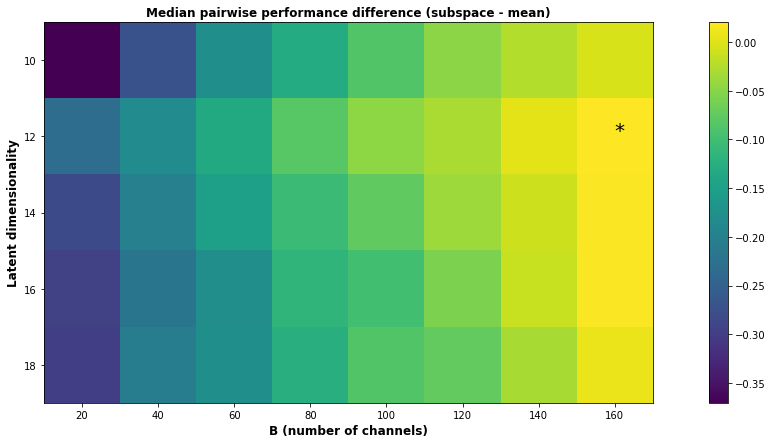

In [435]:
grid_meanscores = np.median(dayB_latentscores - dayB_fullscores[1, :], axis = 2)
opt_D, opt_B    = np.unravel_index(grid_meanscores.argmax(), grid_meanscores.shape)

plt.imshow(grid_meanscores)
plt.text(opt_B, opt_D, '*', fontsize = 20)
plt.xlabel('B (number of channels)', fontweight = 'bold', fontsize = 12)
plt.ylabel('Latent dimensionality', fontweight = 'bold', fontsize = 12)
plt.title('Median pairwise performance difference (subspace - mean)', fontweight = 'bold')
plt.colorbar()
ax = plt.gca()
ax.set_yticks(np.arange(len(component_sweep)))
ax.set_xticks(np.arange(len(B_sweep)))
ax.set_yticklabels(component_sweep,)
ax.set_xticklabels(B_sweep)

(-1, 1)

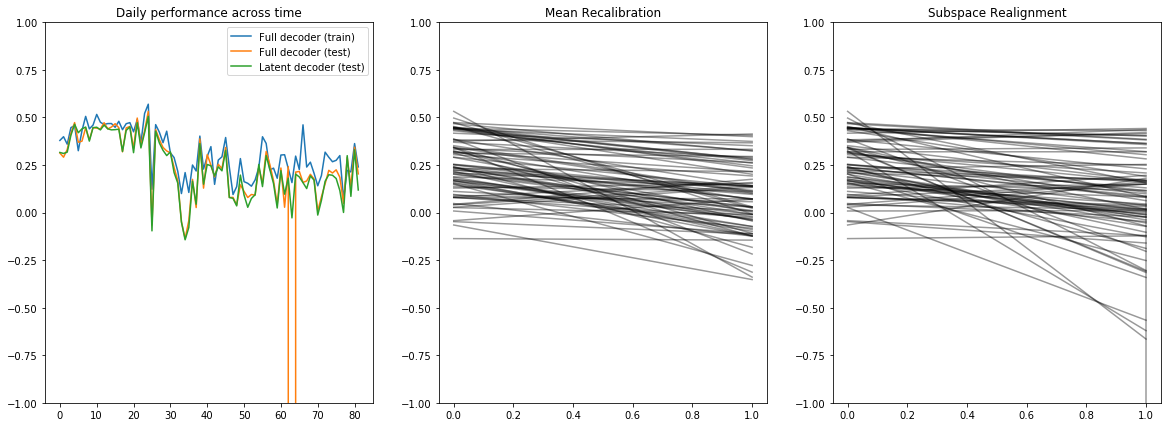

In [438]:
figSize(7, 20)

plt.subplot(1, 3, 1) 
plt.plot(dayA_fullscores[0, :], label = 'Full decoder (train)')
plt.plot(dayA_fullscores[1, :], label = 'Full decoder (test)')
plt.plot(dayA_latentscores[0, :], label = 'Latent decoder (test)')
plt.title('Daily performance across time')
plt.legend('R^2')
plt.ylim([-1, 1])
plt.legend()

plt.subplot(1, 3, 2)
across = np.vstack([dayA_fullscores[1, :], dayB_fullscores[1, :]])
_ = plt.plot(across, color = 'k', alpha = 0.4)
plt.title('Mean Recalibration')
plt.ylim([-1, 1])

plt.subplot(1, 3, 3)
across = np.vstack([dayA_fullscores[1, :], dayB_latentscores[opt_D, opt_B, :]])
_ = plt.plot(across, color = 'k', alpha = 0.4)
plt.title('Subspace Realignment')
plt.ylim([-1, 1])

In [507]:
from sklearn.ensemble import BaggingRegressor

n_bootstraps = 500

# get rid of pesky day with giant nonstationarity:
outliers     = np.where(np.abs(dayB_fullscores[1, :]) > 1000 * np.median(np.abs(dayB_fullscores[1, :])))
non_outliers = np.setdiff1d(np.arange(len(diffs)), outliers)


# build a bootstrapping model:
bootstrap_meanrecal = BaggingRegressor(LinearRegression(), n_estimators = n_bootstraps, bootstrap = True, random_state = 42)
bootstrap_meanrecal.fit(np.asarray(diffs)[non_outliers, np.newaxis], dayB_fullscores[1, non_outliers])

bootstrap_subspace = BaggingRegressor(LinearRegression(), n_estimators = n_bootstraps, bootstrap = True, random_state = 42)
bootstrap_subspace.fit(np.asarray(diffs)[non_outliers, np.newaxis], dayB_latentscores[opt_D, opt_B, non_outliers])

BaggingRegressor(base_estimator=LinearRegression(), n_estimators=500,
                 random_state=42)

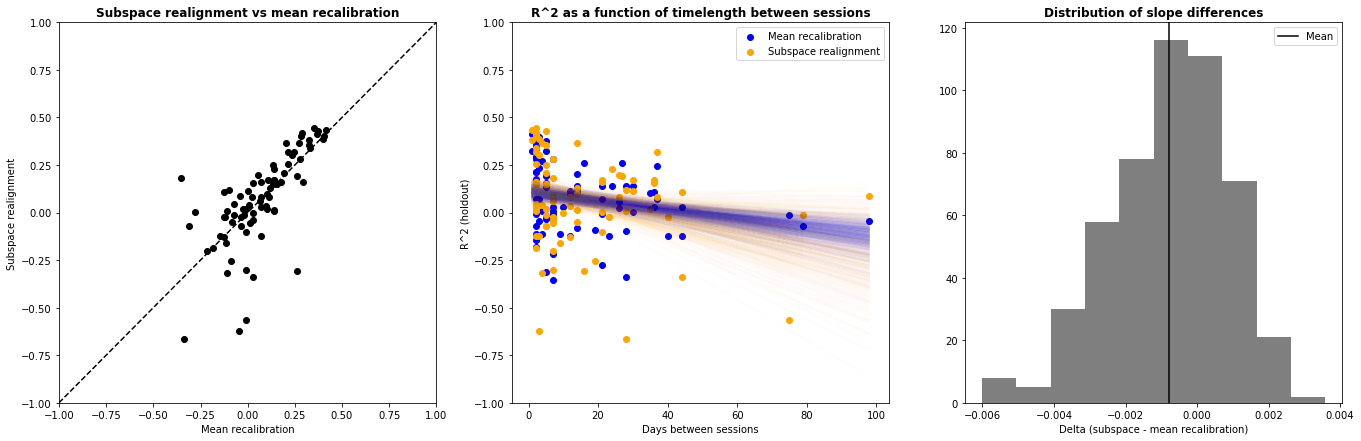

In [523]:
# make some plots, and use bootstrapping to estimate CIs on regression fits:
figSize(7, 23)

plt.subplot(1, 3, 1)
plt.scatter(dayB_fullscores[1, :], dayB_latentscores[opt_D, opt_B, :], color = 'k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.plot([-1, 1], [-1, 1], color = 'k', linestyle = '--')
plt.title('Subspace realignment vs mean recalibration', fontweight = 'bold')
plt.xlabel('Mean recalibration')
plt.ylabel('Subspace realignment')
#plt.ylim([-1, 1])

plt.subplot(1, 3, 2)
for (meanrecal, subspace) in zip(bootstrap_meanrecal.estimators_, bootstrap_subspace.estimators_):
    plt.plot(np.asarray(diffs)[non_outliers, np.newaxis], meanrecal.predict(np.asarray(diffs)[non_outliers, np.newaxis]), alpha = 0.01, color = 'b')
    plt.plot(np.asarray(diffs)[non_outliers, np.newaxis], subspace.predict(np.asarray(diffs)[non_outliers, np.newaxis]), alpha = 0.01, color = 'orange')
    
plt.scatter(diffs, dayB_fullscores[1, :], label = 'Mean recalibration', color = 'b')
plt.scatter(diffs, dayB_latentscores[opt_D, opt_B, :], label = 'Subspace realignment', color = 'orange')
plt.xlabel('Days between sessions')
plt.ylabel('R^2 (holdout)')
plt.title('R^2 as a function of timelength between sessions', fontweight = 'bold')

plt.ylim([-1, 1])
plt.legend()

plt.subplot(1, 3, 3)
slope_diffs = np.concatenate([i.coef_ for i in bootstrap_subspace.estimators_])  - np.concatenate([i.coef_ for i in bootstrap_meanrecal.estimators_])
_ = plt.hist(slope_diffs, color = 'k', alpha = 0.5)
plt.title('Distribution of slope differences', fontweight = 'bold')
plt.xlabel('Delta (subspace - mean recalibration)')
plt.axvline(np.mean(slope_diffs), color = 'k', label = 'Mean')
plt.legend()